In [3]:
import pandas as pd
import numpy as np
import os
import glob
import re # Using regular expressions for robust sorting
import random
import tensorflow as tf

data_folder = "keyboard_training_data/"

In [ ]:
# --- Seeding for reproducibility ---
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

needed_cols = [
    'TimeStamp',
    'Meta_R_Index_Distal_GLOBAL_X',
    'Meta_R_Index_Distal_GLOBAL_Y',
    'Meta_R_Index_Distal_GLOBAL_Z',

    'Meta_R_Index_End_GLOBAL_X',
    'Meta_R_Index_End_GLOBAL_Y',
    'Meta_R_Index_End_GLOBAL_Z',
    'Pressed_Letter'
]




# --- This list will hold the final, clean DataFrames for each session ---
all_session_dfs = []



# --- Discover Participant Folders ---
try:
    participant_folders = [f.path for f in os.scandir(data_folder) if f.is_dir()]
except FileNotFoundError:
    print(f"ERROR: The directory '{data_folder}' was not found. Please check the path.")
    participant_folders = []

print(f"Found {len(participant_folders)} participant folders to process.\n")

# --- Main Processing Loop (Iterating through each participant) ---
for folder_path in participant_folders:
    participant_id = os.path.basename(folder_path)
    print(f"--- Processing Participant: {participant_id} ---")

    search_pattern = os.path.join(folder_path, '*.csv')
    csv_files = glob.glob(search_pattern)

    if not csv_files:
        print("  -> No CSV files found, skipping.\n")
        continue

    # --- Sort files chronologically using the timestamp in the filename ---
    def get_sort_key(filepath):
        matches = re.findall(r'(\d+\.\d+)\.csv', os.path.basename(filepath))
        return float(matches[-1]) if matches else 0

    csv_files.sort(key=get_sort_key)

    # Concatenate all files FOR THIS PARTICIPANT ONLY
    session_dfs = [pd.read_csv(file,  low_memory=False) for file in csv_files]
    if session_dfs:
        session_df = pd.concat(session_dfs, ignore_index=True)
        all_session_dfs.append(session_df)
        print(f"  -> Success! Created a session DataFrame with shape: {session_df.shape}")


print("\n--- Smart Concatenation Complete ---")
print(f"Processed {len(all_session_dfs)} total sessions.")

Found 1 participant folders to process.

--- Processing Participant: p_10 ---


In [ ]:
def process_quest_file(file_path):
    """
    Loads a single data file, filters empty files, downsamples it,
    and calculates features.
    """
    df = pd.read_csv(file_path, low_memory=False)
    
    # --- NEW: Add this block to skip files with no taps ---
    if 'KeyPressFlag' not in df.columns or df['KeyPressFlag'].sum() == 0:
        print(f"  -> Skipping {os.path.basename(file_path)}: No tap events found.")
        return None
    # --- END OF NEW BLOCK ---
    

In [ ]:
from scipy.signal import savgol_filter
import numpy as np
import pandas as pd

print("--- Starting Advanced Feature Engineering ---")

# A list to hold the newly processed DataFrames from each session
processed_sessions = []

# Define all the fingertips we want to process
fingers = [
    'Thumb', 'Index', 'Middle', 'Ring', 'Little'
]
hands = ['L', 'R']
axes = ['X', 'Y', 'Z']

# Create a list of all the position columns we'll need and generate feature names
position_columns = ['TimeStamp', 'KeyPressFlag', 'Pressed_Letter']
feature_names = []
# Iterating through all the hands and fingers and axes to get the position columns
for hand in hands:
    for finger in fingers:
        for axis in axes:
            col_name = f'Meta_{hand}_{finger}_Distal_GLOBAL_{axis}'
            position_columns.append(col_name)
            
            # Also define names for the new features we will create
            feature_names.extend([
                f'pos_{hand}_{finger}_{axis.lower()}',
                f'vel_{hand}_{finger}_{axis.lower()}',
                f'accel_{hand}_{finger}_{axis.lower()}'
            ])


# --- Main Feature Engineering Loop ---
# This will iterate through each participant's session data from your previous step
for i, session_df in enumerate(all_session_dfs):
    print(f"Processing session {i+1}/{len(all_session_dfs)}...")
    
    # Make sure all required columns exist in this session's data
    if not all(col in session_df.columns for col in position_columns):
        print(f"  -> Skipping session {i+1} due to missing columns.")
        continue
        
    # Create a new dataframe for the processed features
    processed_df = session_df[['TimeStamp', 'KeyPressFlag', 'Pressed_Letter']].copy()

    # Calculate features for each finger individually
    for hand in hands:
        for finger in fingers:
            # Savitzky-Golay filter parameters (you can tune these)
            window_length = 11  # Must be an odd number
            polyorder = 3
            
            # Ensure window_length is not larger than the data
            if len(session_df) < window_length:
                continue

            # Calculate the time delta 'dt' for this session
            dt = session_df['TimeStamp'].diff().median()
            if pd.isna(dt) or dt <= 0:
                dt = 1/90.0 # Fallback to 90Hz

            for axis in axes:
                pos_col = f'Meta_{hand}_{finger}_Distal_GLOBAL_{axis}'
                
                # Get the raw position data as a numpy array
                pos_raw = session_df[pos_col].to_numpy()
                
                # Apply the Savitzky-Golay filter to smooth and calculate derivatives
                pos_smooth = savgol_filter(pos_raw, window_length, polyorder, deriv=0, delta=dt)
                vel_smooth = savgol_filter(pos_raw, window_length, polyorder, deriv=1, delta=dt)
                accel_smooth = savgol_filter(pos_raw, window_length, polyorder, deriv=2, delta=dt)
                
                # Add the new, clean features to our processed dataframe
                processed_df[f'pos_{hand}_{finger}_{axis.lower()}'] = pos_smooth
                processed_df[f'vel_{hand}_{finger}_{axis.lower()}'] = vel_smooth
                processed_df[f'accel_{hand}_{finger}_{axis.lower()}'] = accel_smooth
    
    # Clean up any potential NaN/Infinity values and add the processed data to our list
    processed_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    processed_df.dropna(inplace=True)
    processed_sessions.append(processed_df)

# --- Final Combination ---
if processed_sessions:
    master_df_featured = pd.concat(processed_sessions, ignore_index=True)
    print("\n--- Feature Engineering Complete ---")
    print("Shape of the final featured DataFrame:", master_df_featured.shape)
    print("\nExample of new feature columns created:")
    print(master_df_featured[['pos_R_Index_x', 'vel_R_Index_x', 'accel_R_Index_x']].head())
else:
    print("\nNo data was processed. Check your input dataframes.")


--- Starting Advanced Feature Engineering ---
Processing session 1/1...

--- Feature Engineering Complete ---
Shape of the final featured DataFrame: (19609, 93)

Example of new feature columns created:
   pos_R_Index_x  vel_R_Index_x  accel_R_Index_x
0       0.137068       0.017703        -1.093732
1       0.137149       0.011419        -1.166647
2       0.137194       0.004730        -1.239563
3       0.137201      -0.002365        -1.312478
4       0.137167      -0.009865        -1.385394


--- Creating Visualization of Tap Locations ---
Found 118 distinct tap events to visualize.


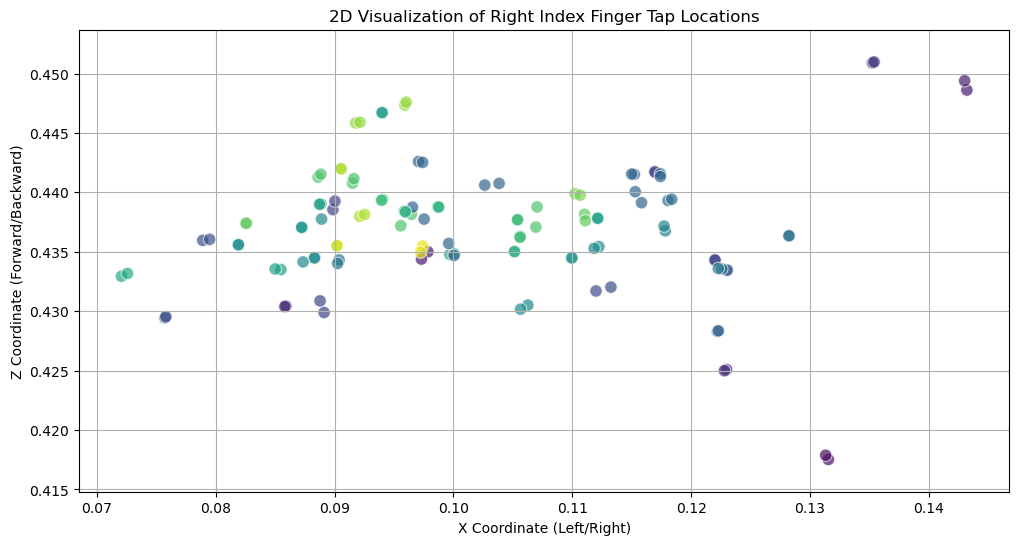

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Creating Visualization of Tap Locations ---")

# First, create a smaller dataframe that only contains the rows where a tap occurred.
# We also select only the columns we need for this plot.
tap_events_df = master_df_featured[master_df_featured['KeyPressFlag'] == 1][[
    'pos_R_Index_x', 
    'pos_R_Index_z', 
    'Pressed_Letter'
]].copy()

print(f"Found {len(tap_events_df)} distinct tap events to visualize.")

# Create the 2D scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=tap_events_df,
    x='pos_R_Index_x',
    y='pos_R_Index_z',
    hue='Pressed_Letter', # Color each point by the letter that was pressed
    palette='viridis',    # A nice color map
    s=80,                 # Size of the points
    alpha=0.7,            # Transparency
    legend=False          # Turn off the legend for clarity
)

plt.title('2D Visualization of Right Index Finger Tap Locations')
plt.xlabel('X Coordinate (Left/Right)')
plt.ylabel('Z Coordinate (Forward/Backward)')
plt.grid(True)
plt.axis('equal') # Ensure the scaling of X and Z axes is the same
plt.show()

In [14]:
import numpy as np

print("--- Preparing Data for Time-Series Windowing ---")

# --- Step 1: Define the full list of features for all 10 fingers ---
feature_columns = []
fingers = ['Thumb', 'Index', 'Middle', 'Ring', 'Little']
hands = ['L', 'R']
feature_types = ['pos', 'vel', 'accel']
axes = ['x', 'y', 'z']

for hand in hands:
    for finger in fingers:
        for feature in feature_types:
            for axis in axes:
                feature_columns.append(f'{feature}_{hand}_{finger}_{axis}')

# --- Step 2: Prepare the data array for the windowing function ---
# The function expects the label ('KeyPressFlag') in the first column
timeseries_data = master_df_featured[['KeyPressFlag'] + feature_columns].to_numpy()

print(f"Data prepared with {timeseries_data.shape[1] - 1} features.")


# --- Step 3: Use the windowing function ---
def make_timeseries_instances(time_series, window_size):
    """Chops the data into overlapping windows."""
    X = []
    y = []
    # We start from window_size to have enough data for the first window
    for i in range(window_size, time_series.shape[0]):
        # The window consists of the previous 'window_size' frames of feature data
        X.append(time_series[i-window_size:i, 1:]) # Features start from column 1
        # The label is the KeyPressFlag at the end of that window
        y.append(time_series[i, 0])
    return np.array(X), np.array(y).astype(int)

# You can tune this window size. 20-30 is a good starting point.
window_size = 25 

print(f"\nCreating time-series windows with a size of {window_size} frames...")
X_windowed, y_windowed = make_timeseries_instances(timeseries_data, window_size)

# --- Step 4: Verify the result ---
# The shape of X should be (number_of_samples, window_size, number_of_features)
print("\n--- Windowing Complete ---")
print("Shape of X_windowed:", X_windowed.shape)
print("Shape of y_windowed:", y_windowed.shape)



--- Preparing Data for Time-Series Windowing ---
Data prepared with 90 features.

Creating time-series windows with a size of 25 frames...

--- Windowing Complete ---
Shape of X_windowed: (19584, 25, 90)
Shape of y_windowed: (19584,)


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

print("--- Starting Model Training & Evaluation ---")

# --- Step 1: Split the Data into Training and Testing Sets ---
# We use stratify=y_windowed to ensure both sets have a representative number of tap events.
X_train, X_test, y_train, y_test = train_test_split(
    X_windowed, y_windowed, test_size=0.2, random_state=42, stratify=y_windowed
)

print(f"Data split into {len(X_train)} training samples and {len(X_test)} testing samples.")

# --- Step 2: Scale the Feature Data ---
# Neural networks perform best when input data is scaled to have a mean of 0 and a standard deviation of 1.
# We must fit the scaler ONLY on the training data to avoid data leakage from the test set.
scaler = StandardScaler()

# Reshape the 3D data to 2D for scaling
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

# Fit on training data and transform both sets
X_train_scaled_reshaped = scaler.fit_transform(X_train_reshaped)
X_test_scaled_reshaped = scaler.transform(X_test_reshaped)

# Reshape the data back to its original 3D shape for the LSTM
X_train_scaled = X_train_scaled_reshaped.reshape(X_train.shape)
X_test_scaled = X_test_scaled_reshaped.reshape(X_test.shape)

print("Feature data has been successfully scaled.")

# --- Step 3: Build the Bidirectional LSTM Model ---
print("\nBuilding the BiLSTM model...")
model = Sequential([
    # The Bidirectional wrapper allows the LSTM to process the sequence forwards and backwards.
    Bidirectional(LSTM(64, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), unroll=True)),
    Dropout(0.5), # Dropout helps prevent the model from overfitting.
    Dense(32, activation='relu'),
    # The final Dense layer with a 'sigmoid' activation outputs a single probability (0 to 1).
    Dense(1, activation='sigmoid') 
])

# Compile the model with an optimizer, loss function, and metrics to track.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# --- Step 4: Train the Model ---
# Calculate class weights to handle the imbalanced dataset (very few 'tap' events).
# This tells the model to pay much more attention to the rare 'tap' class.
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i : weights[i] for i in range(len(weights))}

print("\nTraining the BiLSTM model... (This may take some time)")
# EarlyStopping will stop the training if the validation loss doesn't improve after 3 epochs.
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_scaled,
    y_train,
    epochs=20, # Set a max number of epochs
    batch_size=256,
    validation_split=0.2, # Use 20% of training data for validation
    class_weight=class_weights,
    callbacks=[early_stopping]
)

# --- Step 5: Evaluate the Final Model ---
print("\n--- Evaluating the final model on the test set ---")
# Predict probabilities on the test set
y_pred_probs = model.predict(X_test_scaled)
# Use a 0.5 threshold to convert probabilities to binary predictions (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int)

print("\nFinal BiLSTM Model Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Tap (0)', 'Tap (1)']))


--- Starting Model Training & Evaluation ---
Data split into 15667 training samples and 3917 testing samples.
Feature data has been successfully scaled.

Building the BiLSTM model...


c:\Users\saad_\anaconda3\envs\tf_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Training the BiLSTM model... (This may take some time)
Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9146 - loss: 0.7459 - val_accuracy: 0.9145 - val_loss: 0.4412
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8911 - loss: 0.4189 - val_accuracy: 0.9043 - val_loss: 0.3310
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9150 - loss: 0.2714 - val_accuracy: 0.9352 - val_loss: 0.2027
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9409 - loss: 0.1503 - val_accuracy: 0.9496 - val_loss: 0.1474
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9473 - loss: 0.1452 - val_accuracy: 0.9595 - val_loss: 0.1125
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.9629 - loss: 0.1150 - val_accuracy: 0.9608 - val_loss: 0.1101
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9631 - loss: 0.0875 - val_accuracy: 0.9662 - val_loss: 0.0950
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - ac

In [16]:
model.save('keyboard_classifier_models/keyboard_tap.keras')  # Save the model for later use

In [17]:
model = tf.keras.models.load_model('keyboard_classifier_models/keyboard_tap.keras')

# Export it to a new directory
model.export('keyboard_classifier_models/keyboard_tap')

INFO:tensorflow:Assets written to: keyboard_classifier_models/keyboard_tap\assets


INFO:tensorflow:Assets written to: keyboard_classifier_models/keyboard_tap\assets


Saved artifact at 'keyboard_classifier_models/keyboard_tap'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 25, 90), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2474396689680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2474396688144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2474396687376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2474396682960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2474396690448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2474396687568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2474396686416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2474396690256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2474577298064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2474577297872: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [2]:
import tf2onnx

!python -m tf2onnx.convert \
  --saved-model "C:\Users\SyMoN\Documents\Project\text_entry_saad\vr_text_entry\typing_classifier\keyboard_classifier_models\keyboard_tap" \
  --output "C:\Users\SyMoN\Documents\Project\text_entry_saad\vr_text_entry\typing_classifier\keyboard_classifier_models\keyboard_tap.onnx" \
  --opset 13



<frozen runpy>:128: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
2025-08-19 11:32:09,010 - WARNING - ***IMPORTANT*** Installed protobuf is not cpp accelerated. Conversion will be extremely slow. See https://github.com/onnx/tensorflow-onnx/issues/1557
2025-08-19 11:32:09,019 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2025-08-19 11:32:10,528 - INFO - Signatures found in model: [serve,serving_default].
2025-08-19 11:32:10,528 - WARNING - '--signature_def' not specified, using first signature: serve
2025-08-19 11:32:10,529 - INFO - Output names: ['output_0']
I0000 00:00:1755599530.712309   18380 devices.cc:76] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
I0000 00:00:1755599530.712627   18380 single_machine.cc:374] Starting new session
I0000 00:

In [19]:
import tf2onnx
import tensorflow as tf

saved_model_dir = r"C:\Users\SyMoN\Documents\Project\text_entry_saad\vr_text_entry\typing_classifier\keyboard_classifier_models\keyboard_tap"
output_path = r"C:\Users\SyMoN\Documents\Project\text_entry_saad\vr_text_entry\typing_classifier\Models\keyboard.onnx"

# Load the TensorFlow model
model = tf.saved_model.load(saved_model_dir)

# Convert to ONNX
spec = (tf.TensorSpec((None, 100, 6), tf.float32, name="input"),)  # adjust shape if needed
onnx_model, _ = tf2onnx.convert.from_function(
    model.signatures["serving_default"],
    input_signature=spec,
    opset=13,
    output_path=output_path
)

print(f"ONNX model saved to: {output_path}")

OSError: SavedModel file does not exist at: C:\Users\SyMoN\Documents\Project\text_entry_saad\vr_text_entry\typing_classifier\keyboard_classifier_models\keyboard_tap\{saved_model.pbtxt|saved_model.pb}